# Notebook 3: Scholars
My intuition is that information about the authors of a paper should be helpful as well in determining the novelty of a paper. With that, I have created a script (`scripts/scrape_scholars_data.py`) to scrape author profile information from Google Scholar over a span of multiple days. The results are saved in `data/scraped/scholars.pkl`. 

This notebook is used to parse the results into a `scholars` dataframe and save it to be used later for calculating the Author Score.

In [1]:
import numpy as np
import pandas as pd

import plotly.figure_factory as ff
import plotly.io as pio

from IPython.display import Image

### Retrieve Scholars Profiles

In [2]:
scholars = pd.read_pickle('data/scraped/scholars.pkl')
scholars = scholars.set_index('scholar')
scholars.head()

,freq,profile
scholar,,
Yoshua Bengio,88,"{'_filled': True,\n 'affiliation': 'Professor,..."
Uwe Aickelin,84,"{'_filled': True,\n 'affiliation': 'School of ..."
Marcus Hutter,78,"{'_filled': True,\n 'affiliation': 'Researcher..."
Chunhua Shen,75,"{'_filled': True,\n 'affiliation': 'School of ..."
Joseph Halpern,66,"{'_filled': True,\n 'affiliation': 'Professor ..."


Not all scholar profiles were found on Google Scholar. For those with a profile, the profile data may look something like this:

In [3]:
scholars.at['Yoshua Bengio', 'profile'].__dict__

{'id': 'kukA0LcAAAAJ',
 'url_picture': 'https://scholar.google.com/citations?view_op=medium_photo&user=kukA0LcAAAAJ',
 'name': 'Yoshua Bengio',
 'affiliation': 'Professor, U. Montreal (Computer Sc. & Op. Res.), Mila, CIFAR, CRM, IVADO, REPARTI, GRSNC',
 'interests': ['Machine learning', 'deep learning', 'artificial intelligence'],
 '_filled': True,
 'citedby': 171496,
 'citedby5y': 153102,
 'hindex': 137,
 'hindex5y': 126,
 'i10index': 439,
 'i10index5y': 375,
 'cites_per_year': {2003: 489,
  2004: 524,
  2005: 702,
  2006: 820,
  2007: 924,
  2008: 1044,
  2009: 1257,
  2010: 1578,
  2011: 1888,
  2012: 2473,
  2013: 3882,
  2014: 6639,
  2015: 12383,
  2016: 23563,
  2017: 37047,
  2018: 59902,
  2019: 13122}}

For easy data manipulation going forward, I have saved pertinent information from the profiles into new dataframe columns.

The new columns and their definition are as follow:
- `h-index`: The number $h$ is the maximum number of articles that has been cited at least $h$ times
- `i10-index`: The number of articles cited at least 10 times
- `citedby`: The total number of citations received for all publications
- `avg_citedby_2015`: The average number of citations received for years before 2015, inclusive.

In [4]:
def avg_cites(x, by=2015):
    if not hasattr(x, 'cites_per_year'):
        return 'N/A'
    
    cites = [v for k, v in x.cites_per_year.items() if k <= by]
    
    if not len(cites):
        return 'N/A'
    
    return int(np.mean(cites))

In [5]:
scholars['h-index'] = scholars['profile'].apply(lambda x: x.hindex if hasattr(x, 'hindex') else 'N/A')
scholars['i10-index'] = scholars['profile'].apply(lambda x: x.i10index if hasattr(x, 'i10index') else 'N/A')
scholars['citedby'] = scholars['profile'].apply(lambda x: x.citedby if hasattr(x, 'citedby') else 'N/A')
scholars['avg_citedby_2015'] = scholars['profile'].apply(avg_cites)

# Save dataframe
scholars.to_pickle('data/dataframes/scholars_df.pkl')

---
# Visualization

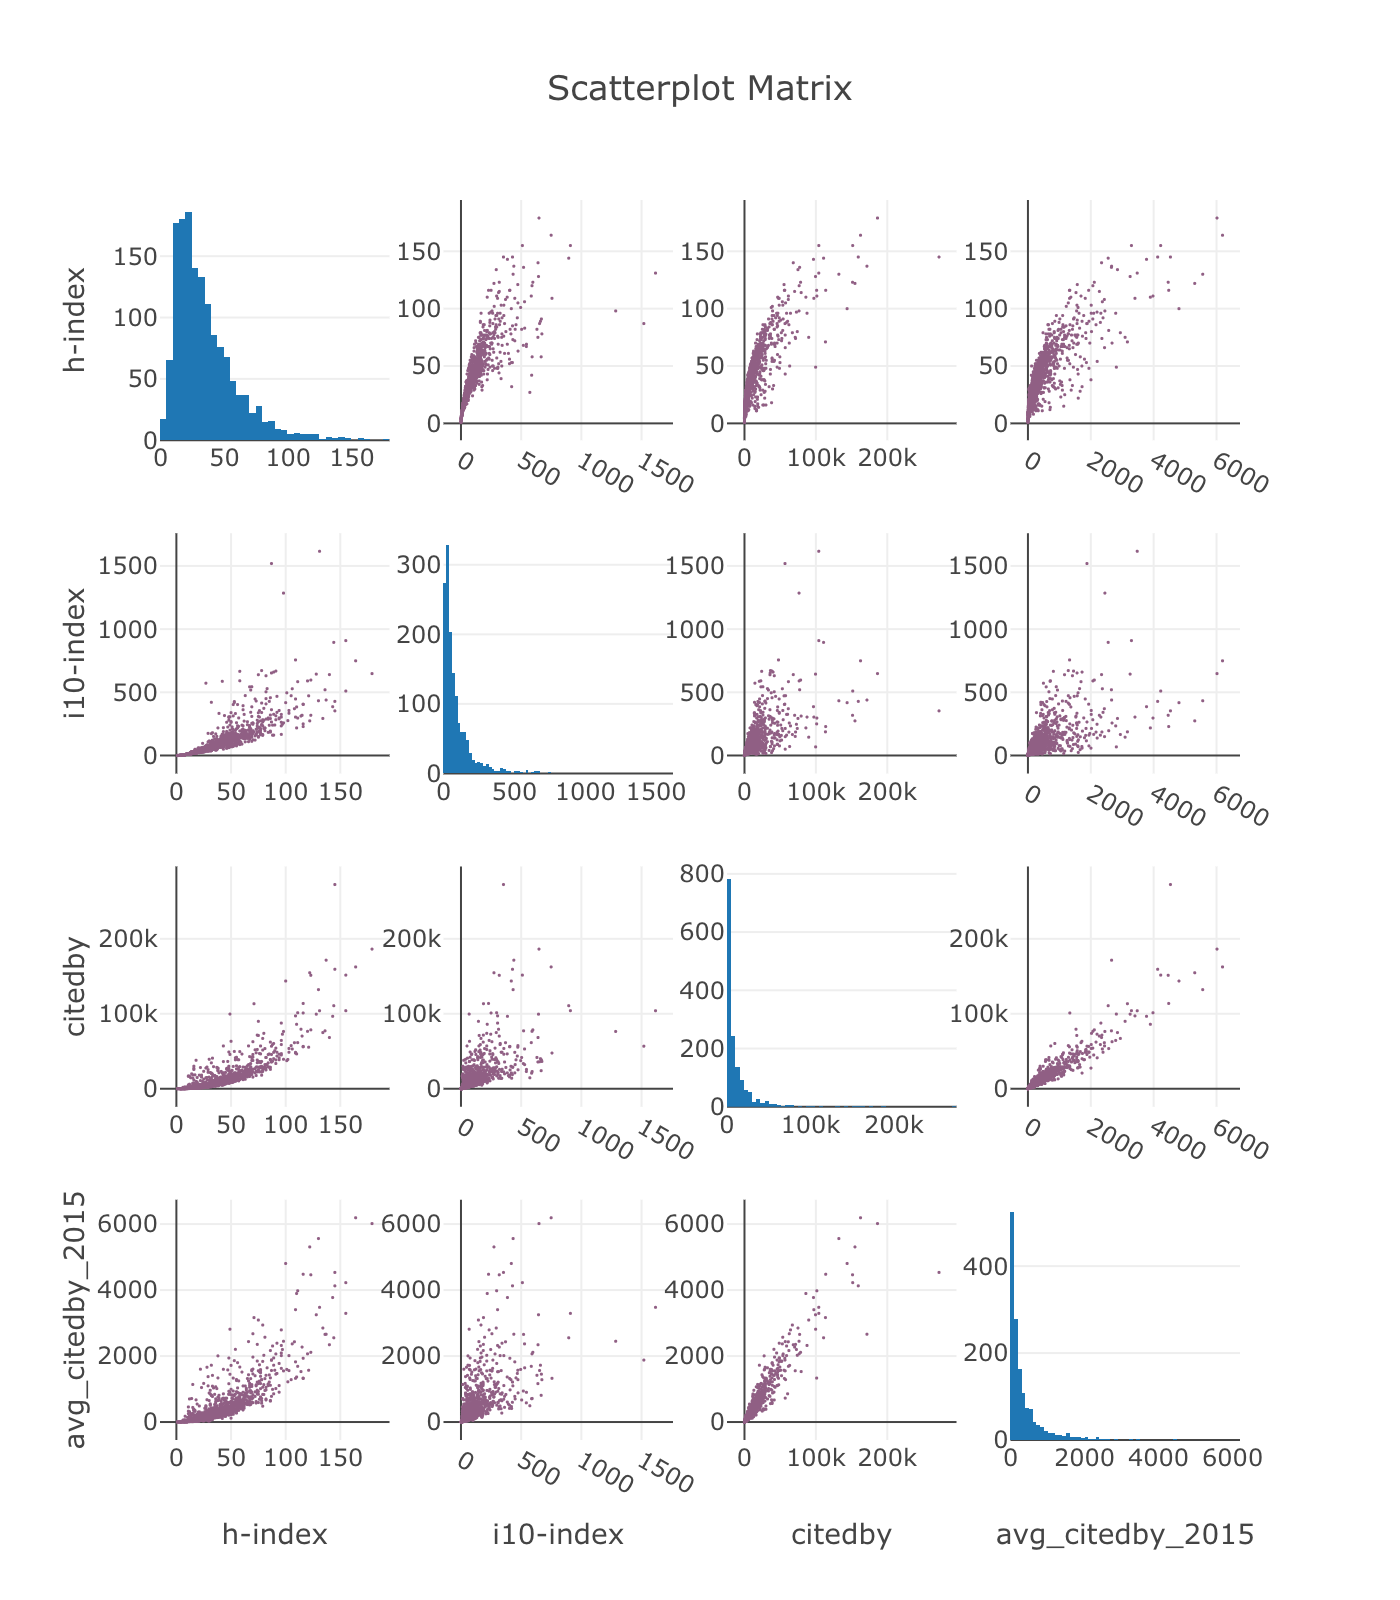

In [6]:
# Filter for scholars with a Google Scholar profile
for_plotting = scholars[~scholars.applymap(lambda x: isinstance(x, str)).any(axis=1)]
for_plotting['dummy'] = pd.Categorical([1] * len(for_plotting))  # Hack: Dummy column to set all plots below to the same colour

# Create figure
fig = ff.create_scatterplotmatrix(for_plotting.iloc[:1500, -5:], diag='histogram', index='dummy', 
                                  height=700, width=700, size=1.5)

# Disable colorbar display
for trace in fig['data']:
    if type(trace).__name__ == 'Scatter':
        trace.marker.showscale = False

# Save and display image
pio.write_image(fig, 'images/ScholarMetrics.png', width=700, height=800, scale=2)
Image("images/ScholarMetrics.png", width=700, height=800)

The image above depicts a pairwise scatterplot matrix between the four columns that I have created previously. Graphs on the diagonal are the histogram for the $i$-th variable, while the graph at column $c$ and row $r$ show the scatterplot of variable $r$ vs. variable $c$.

In the plot above, we can see from the histograms that the data is highly skewed. Furthermore, the four variables are highly correlated with one another, except for `i10-index`-`citedby` and `i10-index`-`avg_citedby_2015` pairs. The extremely high correlation between `citedby` and `avg_citedby_2015` is not surprising given that the latter is a linearly-transformed subset of another. 

Given the high correlations between these variables, I chose to only **use the `h-index` in the subsequent analysis**. The reason for using `h-index` is that it is the best measure of quality amongst the four metrics.